# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

**WARNING:** We often experienced loss spikes in this examples which caused model training to fail or slow down. There is a [GitHub issue](https://github.com/lvwerra/trl/issues/101) to track the issue.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [1]:
# !pip install trl==0.11.4

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import random
import torch
import wandb
import time
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt

tqdm.pandas()
import sys
sys.path.append('/root/autodl-tmp/commit_generative_reinforcement_learning')
from datasets import load_dataset

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

from trl import (
    PPOTrainer,
    PPOConfig,
    AutoModelForCausalLMWithValueHead,
    create_reference_model,
)
from trl import AutoModelForSeq2SeqLMWithValueHead
# from trl.experimental.ppo import PPOTrainer

### Configuration

In [4]:
commit_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}

config = PPOConfig(
    model_name="/root/autodl-tmp/models/codet5-base",
    steps=51200,
    learning_rate=1.41e-5,
    remove_unused_columns=False,
    log_with="wandb",
    batch_size=32,
    mini_batch_size=32,
    kl_penalty="kl",
    kl_coef=0.5,
)

txt_in_len = 5
txt_out_len = 20
seed = 1


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(


In [5]:
# np.random.seed(seed)

You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://huggingface.co/papers/1909.08593). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [6]:
policy_name = "/root/autodl-tmp/models/codet5-base"
tokenizer = AutoTokenizer.from_pretrained(policy_name)

# 1) policy / ref policy: Seq2Seq + value head
policy = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(policy_name)
ref_policy = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(policy_name)

In [7]:
# 确保 eos_token_id 是正数
print("eos_token_id:", tokenizer.eos_token_id)
print("pad_token_id:", tokenizer.pad_token_id)

eos_token_id: 2
pad_token_id: 0


### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [12]:
from datasets import load_dataset
# 使用自己的CSV文件
dataset = load_dataset(
     "csv",
    data_files="/root/autodl-tmp/CommitFit/dataset/Ghadhab/dataset.csv",  # 替换为你的文件路径
    split="train"
)


In [13]:
# from transformers import AutoModelForSequenceClassification

# # reward_model = AutoModelForSequenceClassification.from_pretrained(
# #     "/root/autodl-tmp/CommitFit/notebooks/E-3-best(70%)/my_awesome_model/checkpoint-390"
# # )

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [14]:
dataset

Dataset({
    features: ['user', 'repo', 'commit', 'labels', 'msgs', 'diffs', 'feature'],
    num_rows: 1781
})

In [15]:
dataset = dataset.map(
    lambda x: {
        "input_ids": tokenizer.encode("Please read the following code and write comments in natural language:\n" + x["diffs"][:500]+"\nComments:", return_tensors="pt")[
            0, :txt_in_len
        ]
    },
    batched=False,
    # disable_tqdm=False
)
dataset = dataset.map(
    lambda x: {"query": tokenizer.decode(x["input_ids"])}, batched=False
)
dataset = dataset[:20480]

from datasets import Dataset

dataset = Dataset.from_dict(dataset)
dataset.set_format("pytorch")

In [16]:
dataset[3]["input_ids"]

tensor([   1, 8496,  855,  326, 3751])

In [17]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [18]:
ppo_trainer = PPOTrainer(
    config, policy, ref_policy, tokenizer, dataset, data_collator=collator
)

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tongjiajun1992 (tongjiajun1992-china-university-of-mining-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [19]:
from transformers import AutoModelForSequenceClassification

In [20]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
else:
    device = ppo_trainer.accelerator.device
commit_pipe = pipeline(
    "text-classification", "/root/autodl-tmp/CommitFit/notebooks/E-3-best(70%)/my_awesome_model/checkpoint-390", device=device
)

Device set to use cuda:0


The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [21]:
text = "Change hasException to hasThrowable--"
output = commit_pipe(text, **commit_pipe_kwargs)
output

[{'label': 'LABEL_2', 'score': 3.4907901287078857},
 {'label': 'LABEL_1', 'score': -1.3687688112258911},
 {'label': 'LABEL_0', 'score': -2.0189154148101807}]

In [22]:
text = "Trying to extend the Scheduler interface according- to the comments at -19.--"
output = commit_pipe(text, **commit_pipe_kwargs)
output

[{'label': 'LABEL_0', 'score': 3.8293192386627197},
 {'label': 'LABEL_1', 'score': -1.248435616493225},
 {'label': 'LABEL_2', 'score': -2.0435798168182373}]

In [23]:
text = "RunAsync method for outputting multiple values--"
output = commit_pipe(text, **commit_pipe_kwargs)
output

[{'label': 'LABEL_0', 'score': 3.5676469802856445},
 {'label': 'LABEL_1', 'score': -1.4358106851577759},
 {'label': 'LABEL_2', 'score': -1.7680931091308594}]

The resulting reward signal:

In [24]:
def extract_pipe_output(outputs):
    logits_dicts = []
    for out in outputs:    # 每个样本
        logits = {element["label"]: element["score"] for element in out}
        logits_dicts.append(logits)
    return logits_dicts

In [25]:
output[1]["score"]

-1.4358106851577759

### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [26]:
# import torch
# 定义控制标签
ctrl_str = ["[Adaptive]", "[Perfective]", "[Corrective]"]

# 自动选择设备（GPU 优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 把 control string 编码成 token，用于 prepend 到输入
ctrl_tokens = {
    s: tokenizer.encode(s, return_tensors="pt").squeeze().to(device)
    for s in ctrl_str
}


In [27]:
ctrl_tokens

{'[Adaptive]': tensor([    1,    63, 13716,   688,    65,     2], device='cuda:0'),
 '[Perfective]': tensor([    1,    63, 22016,   386,   688,    65,     2], device='cuda:0'),
 '[Corrective]': tensor([    1,    63, 16147,   688,    65,     2], device='cuda:0')}

### Reward function

In [28]:
label_map = {
    "[Adaptive]": "LABEL_0",
    "[Perfective]": "LABEL_1",
    "[Corrective]": "LABEL_2"
}

In [ ]:
def language_quality_reward(text):
    # 1) 长度约束
    if len(text.split()) < 5:
        return -0.3

    # 2) 禁止 URL / License / Copyright
    blacklist = ["http", "www", "license", "copyright", "©"]
    if any(b in text.lower() for b in blacklist):
        return -0.5

    # 3) 简单句子结构奖励
    if text[0].isupper():
        return 0.2

    return 0.0

In [29]:
def task_logit_to_reward(logits, tasks):
    """
    logits: List[Dict] 每个样本的分类结果
    tasks:  List[str]  目标类别 ['[Adaptive]', '[Perfective]', '[Corrective]']
    """
    rewards = []
    for logit, task in zip(logits, tasks):
        # print(logit)
        mapped_task = label_map[task]   # 把 [Adaptive] → Adaptive
        if mapped_task not in logit:
            raise ValueError(f"Unknown task {mapped_task}, must be one of {list(logit.keys())}")
        rewards.append(torch.tensor(logit[mapped_task]))
    return rewards


The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets ['Adaptive','Perfective','Corrective']. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [30]:
print(ctrl_str)

['[Adaptive]', '[Perfective]', '[Corrective]']


In [31]:
logits = [
    {"LABEL_0": 0.7, "LABEL_1": 0.2, "LABEL_2": 0.1},   # 样本1
    {"LABEL_0": 0.1, "LABEL_1": 0.6, "LABEL_2": 0.3},   # 样本2
    {"LABEL_0": 0.2, "LABEL_1": 0.1, "LABEL_2": 0.7},   # 样本3
]

In [32]:
task_logit_to_reward(logits, ctrl_str)

[tensor(0.7000), tensor(0.6000), tensor(0.7000)]

In [33]:
# task_logit_to_reward(torch.Tensor([-4, -4, -4]), ctrl_str)

In [34]:
# task_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

### Generation settings

In [35]:
generation_kwargs = {
    "min_length": 1,   # -1 会报错，改成 1 或 0
    "top_k": 0,        # 设为 0 表示不启用 top-k
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": txt_out_len,
    "eos_token_id": tokenizer.eos_token_id,
}

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [36]:
TASK2LABEL = {
    "[Corrective]": "LABEL_2",
    "[SomeTask]": "LABEL_1",
    "[Another]": "LABEL_0",
}

LABEL2ID = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}

In [37]:
for epoch in range(10):
    for batch in tqdm(ppo_trainer.dataloader):
        (
            logs,
            game_data,
        ) = (
            dict(),
            dict(),
        )

        #### prepend a random control token
        task_list = choices(ctrl_str, k=config.batch_size)
        # print(task_list)
        game_data["query"] = [t + q for t, q in zip(task_list, batch["query"])]
        query_tensors = [
            torch.cat((ctrl_tokens[t], input_ids))
            for t, input_ids in zip(task_list, batch["input_ids"])
        ]

        #### get response from gpt2
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze())
            # print(response)
        game_data["response"] = [
            tokenizer.decode(r.squeeze(), skip_special_tokens=True, clean_up_tokenization_spaces=True,) for r in response_tensors
        ]
        
        #### commit analysis
        texts = [r for q, r in zip(batch["query"], game_data["response"])]
        print(texts)
        logits = extract_pipe_output(commit_pipe(texts, **commit_pipe_kwargs))
        # print(task_list)
        rewards = task_logit_to_reward(logits, task_list)
        # print(rewards)
        #### Run PPO training
        t = time.time()
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
        # print(stats)
        for cs in ctrl_str:
            key = "env/reward_" + cs.strip("[]")
            stats[key] = np.mean(
                [r.cpu().numpy() for r, t in zip(rewards, task_list) if t == cs]
            )
        ppo_trainer.log_stats(stats, game_data, rewards)

  0%|          | 0/55 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['Details  [ Notice ]', 'either', 'visible', 'author © 2007-09-08', 'Documentation \\', 'Display 🙨 See the', 'Method : Incorrective', 'ID', 'the', 'read the', 'Information “Corrective”prints', 'beetting mandatory.\\n ↓&#64;Nerde WithNS', 'Open LS Resource – http://wpc.sips.org/28', 'Problem  public class', 'the', 'Data budget functions.\\n \\', '18 / 2013 - 09-22', 'the Version. [ Corrective', 'the', '4.2 or 6.2', 'Corporation Documentation :', 'Examples :', 'the', 'the Mission Retest o', 'read the Integral \'"\'', 'MIT License ] [', '- C 数据的情况', '] public class PetUsersInfo {', 'Data AC Before 2009-05-25 00:00:00 The', 'How To', 'unpublished notes */ ', 'Please']
['on HudiomgovpaudSecTask  final void', 'warning: Do you care? Write', 'events : FOUR_POST_AFTER exceptions ', 'the fish video locksetup file in the future', 'Administration powers<br/>', 'file fuzz you great', 'with permutations versions must append', 'Read: the PDFs reading', 'explained logs for the', 'code from Wikipedia :

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


['read 84shark Pan *************************************************************/ /*!', '] nully. Ty', 'ride the diagram', 'and', '<a href="https://no-ustable.org/notification/">N&#', 'Examples are and back their necessary!', 'Email', 'text\\n] public SEE\\nThe description', 'appack give ad to print...', 'a command from the working', 'information : https://en.bone.io/manual/function-expression-getter.', 'the', 'John Technologies latest for Duncan', 'information for his Product:', 'Recommended file with option -h', 'Shell Docs :', '[ Legacy ] Admit', 'following', "email address at http://keyitoffi.com/Blog/register'era", 'Cont a in the', 'Geocode_MortoData <Alexa>Your company@gmail.com', 'pwti you wanted at http://anyone.linottanie.ru/web', 'arn:<a id="dnr_ref0"; a', 'accessings prints docs', 'documentation', 'ptruff', 'information here or use the', 'RemarkScLOG. err always', 'IMy description ] [ Anonize', 'contents', 'Assesions:', 'Location: http://www.emailapply.com/ protection/subuse

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.80) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['// [Corrective] comment a why', 'a field', 'email the', 'read the server apart', 'the', 'C# Tools Transaction License', ') <br/>user can', 'date created without', 'follows : -------------------------------------------------------------------------- checksum', 'documentation States:', 'the', 'fileategorive.txt you can find the', 'description and end', 'acter: AugIdstylus varianMessages : \\n', 'query for perturbations [Perfective](pau OS)', 'the', 'The user scraped awalksubmissions', 'from the writeLock to', 'class Test { char *', 'amanna jumor predicted values.', '[ Arbian User Licence] Extensibly', 'Secret  [ Comments ]', 'the', 'annotations under the', 'the zero length-string.', 'ul A B o', 'cml files : 权限ドク�', 'Annotations : http://billable.github.io/50041  [', 'all of the', 'read the', 'ad NOT @AggrJaobortex', 'resource']
['Examples', 'address Defeations in your project.', 'description: https://advance.com/Documentation/, An AskHu', 'Corporation plate reason editing :', 'Obtain R

  0%|          | 0/55 [00:00<?, ?it/s]

['the', 'resource :', 'sigh,', '-', 'Information : Adaptive', 'the all and', 'information :', 'a', 'Wiki: trailable,', 'Read the', 'the', 'the', 'not a', 'Message : return :', 'Args:', 'the', 'Read a', 'time :', 'parameters :', 'please', 'Read', ': \\', 'Read', 'The', 'the', 'read file', 'Attributes ) ;', 'read the', 'the', 'the current pages at :', 'the', 'Session Instance']
['Info : Veding', 'build a', 'Read the', 'Authorize a', 'no Token', ')', '@ERROR :', 'the', '-', 'The', 'information', 'a description [Adaptive ]', 'expired', 'a', 'the', 'read your', 'read an overview at ', 'the', 'to configure the project and', '\\ \\\\', 'I', 'Simple Code', 'notes : se', 'the', 'the', 'Hold', 'Name: [Adaptive ]', 'indour c', ',', 'Documentation :', 'description : Read', 'read a file']
['Compute:', 'the', 'the', '755 - am expected and', '. [AdaptiveArgumentHint ]', 'read Write all', 'docs', 'the', "an 'Corrective npiblation'", 'Name : IMPORTANT_Examples', 'Just', 'read the', 'the IgnoreShort', '

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (23.62) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (65.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['the', 'Protected', 'all the', 'Read', 'Information', 'The', 'details : - <title >', 'Information', 'Information', 'Examples:', 'the', ': Doc details :', 'the', 'content :', 'read the', ' the', ': -', 'numbers :', 'the', 'OO', 'Read //', 'the', 'The', '---dienodes An', 'the', 'section :', 'You', ': Test this about', 'read the', ':', 'doc:', 'The']
['thecription', 'Permission:', 'Corporation', 'a', 'Content :', 'Attribute Type', 'Read Users', 'Information', 'a', 'description:', 'chat：靕距び場�', 'The', 'Documentation :', 'member ;', 'Dimension :', 'Location: - Session', ': / @Description', 'Comment :', 'Documentation : The Next description', 'User', 'Examples', 'Examples :', 'Method Description:', 'users', 'Summary:', 'readEachMethodName', 'The', 'the Classes', 'example^', 'description :', '*', 'The']
['Additional attributes :', 'Profile The Part', 'the Resource', 'name and Annotations :', 'Record @icyenticate', 'eSubscription :', 'Write a', 'Information', 'Study Calendar s', 'Member ~ Pic

  0%|          | 0/55 [00:00<?, ?it/s]

['a', 'Listing :', 'a read', 'Name: 必须先參杸', 'The', 'Example :', 'rights: -', 'The Language', 'read the', '- Read the Header', 'You', 'Information', 'ppr Examples', 'contains', 'Bank Det Conversation :', 'Title', 'Information', 'read"', 'Access on the', 'Read a computer', 'Class', 'read a your', 'section: -', 'desc:', 'Name : -', 'information', 'Text name Editors :', '.', 'transmission :', 'the', 'Updb Register Access', 'Please']
['Information', '-', 'Documentation:', 'information - Value', 'the', 'metre:', 'Details File +', 'author:', 'element', 'documents :', 'Information', 'Information', 'or', 'details :', 'details : -', 'Manage a new Type', 'Please', '#FOR Rekis', '"', 'The', 'notes: Open an', 'the', 'the', 'The', 'a class: Read the', 'tag', 'Try', 'a', 'modifiers :', 'Read a', 'the', 'ira Instance!" }']
['Node -', 'read the', 'Title', 'Documentation:', 'it', 'export : -', 'Examples', ': a', 'Name', 'figure', 'the', 'The', 'The', 'the', 'title :', 'section: The', '; [', 'the', 'Read

  0%|          | 0/55 [00:00<?, ?it/s]

['详情容偛点', 'the', 'you', 'read the', 'in the', 'an', 'read', 'read the', 'instructions :', 'Negative', 'Person:', 'the', 'view a', 'Documentation:', 'read a file', '09: The', 'the', 'Please', 'read the new file', 'name:', 'read the', 'read a file', 'the', 'Face Optional?', 'read the', 'the', 'read a file a', 'Documentation:', 'read a *3', 'line :', 'the', 'read a header']
['read your terminal', 'Read the', 'Header:', 'Notes:', 'read aBlank file', 'read:', 'read Info', 'The', 'car o species:', 'read the', 'Editable Description:', 'Eg', 'Read a', 'Name :', 'your company', 'Occur true to', 'Read', 'an', 'read the national', 'a', 'read the', 'Read a message', 'annotations:', 'read the', 'A', 'read the', 'read a symmetric an', 'Annotations:', 'Notes: *', 'email:', 'a', 'Profile:']
['a', 'read your', 'a message', 'read a', 'read the', 'the', 'read a document', 'read the', 'read your', 'read a', 'the', 'Example', 'Information', 'the', 'c(0)', 'Name :', 'the', 'Examples', 'comments:', 'the', 'R

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (294.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['the', 'the', 'the', 'Examples: A', 'the', 'the', 'name : public', 'information :', 'a', 'Information: You', 'information:', 'read a string', 'Documentation :', 'Groups :', 'documents :', 'write a', '*', 'class :', 'author:', 'Read The', 'name:', 'author:', 'the', 'Examples : Clean Database', 'You', 'the', 'Read an', 'name :', 'Annotations :', 'descriptions :  [', 'code : read the //dol outputs:', 'description : a read a']
['also the', 'n.read a', 'name :', 'the', '2. 0. 0:', 'your', 'read a', 'notes :', 'author:', 'a', ':', 'Read a value :', 'the', 'read the', 'read a', 'your company', 'your', 'phone : 如果不传刷', 'or another confirmation', 'locks :', 'your', 'the', 'read a file row :', 'Read the', 'your licenses', 'the', 'groups :  [ an', 'Read the :', 'details : And y the', 'organization:', 'the', 'Deprecated :']
['period DirectionHead the', 'your application', 'Data :  public class SampleIdentifierPercentage {', 'Examples :', 'Data :', ' cytribute', 'read all system metadata', 'contac

  0%|          | 0/55 [00:00<?, ?it/s]

['the', 'Annotations :', 'The', 'read a file', 'Information', 'Name:', 'Profile', 'Linked', 'overview:', 'information:', 'Name:', 'read a file', 'the', ':', 'Name:', 'The Clock', 'Person:', 'read menu', 'read a text file:', 'Comment:', 'member:', 'Annotations :', 'Name:', 'The', 'read the', 'name =', 'Information', 'read the', 'The', 'a better install :', 'in the', 'increments']
['read the', 'Name:', 'read the', 'Information', 'author:Homepage', 'the', 'dusics', 'are the', 'read a', 'email:', 'Read', 'read the', 'Documentation :', 'read the', 'the', 'read a', 'reada positive number', 'competency:', 'Annotations :', 'authors:', 'Cake Case', 'on the system', 'a', 'Person:', 'read a file', ': The', 'The', ':', 'Corporation', 'Add the', 'Comment:', 'read the']
['comment :', 'the', 'Annotations :', 'Information', 'read a message.', 'Comment:', 'read', 'Annotations :', 'Information', 'Comment:', 'the', 'read the', 'a todo', 'month :', 'READ a file', 'email:', 'comments :', 'read the', 'Produ

  0%|          | 0/55 [00:00<?, ?it/s]

['in the', 'in the', 'a pted', 'Information', 'description:', 'Information', 'Read a file :', '条件 ws则本或�', '支持仛到异常', 'a', 'Comment:', 'Asset Resources :', 'Feature:', 'Examples', 'The', 'annotations:', 'read the', 'annotations :', 'contacts:', '规国使需下代', 'books:', 'annotations:', '新构�physical增列表', 'Information', 'read a', 'The', 'the', 'Name/Information : -', 'Youris', 'in the', 'a class Brocharcher: Read', 'annotation:']
['annotations:', 'Write a', 'language :', 'read the current file', 'annotations : -', '如果椚方数条', '来时并发邮直', 'address :', 'the', 'containing countries', 'The', 'Example', 'Examples', 'Component :', 'Annotations :', 'comment:', 'In', 'information', 'read a file :', 'Information', 'the', 'feature:', 'Documentation :', '提供数据ばき', 'x', 'Information', 'read a file at', 'the', 'Information', 'Examples', 'The', 'Information']
['酉列端口抡记', 'ADDAnion orders :', 'words:', 'the', '顾编取斷描运', 'The', 'the', 'rename a file (Path);', 'read a text file :', 'the', 'Information &artifacts', 'li

  0%|          | 0/55 [00:00<?, ?it/s]

['Information', 'Account:', '読明，支持 �', 'in the', 'in the', 'the', 'comment:', 'Notes:', '栒：等玎，筣', 'Annotations:', 'author: a', '会到盘消", 请�', 'file:', '如果为人昐来', 'the', 'evidence :', 'the', 'comments:', 'うきた�Evtに兪', 'The', 'in the', 'another file', 'から内刲でだ', 'Annotations: -', 'Comment :', 'Annotations:', 'read the file ) 交显ど佱�', '布上传仴擅处', 'read a file :', 'Documentation:', 'category:', 'Name : Simple']
['in the', 'Email:', '加解例機提供', '把て�typed添办お', '等状捷恰痶群', '刂，抛出此な', 'the', '放到服务のり', '� Ringposition prior : return', 'File', 'in the', 'in the', 'in the', 'うににてに斓', 'an example', 'in the', 'Comment:', 'in the', 'in the', 'in the', '以使实泥に基', '消しの場なず', 'Panounama Please bkick out:', 'mybatis', 'Documentation:', 'in the', 'In the', 'comment:', 'In the', 'のばた堥にぬ', '回把约仺のへ', 'in the']
['In the', 'the', 'name =', 'title :Index', 'details: -', 'read a document.', 'In the', 'にな留でい� dialog', 'Documentation:', '该远たす。し', 'description:', 'いつなにけに', 'in the', 'ウプサに拑ち', 'なく綱吕そう', 'ography :', 'Indicators',

  0%|          | 0/55 [00:00<?, ?it/s]

['MetaData :', 'Comments: -', 'Annotations', 'そのはスでき', 'up to', 'up for', 'ここれ剱すで', 'member:', 'up and', 'up to', 'up to', 'れ附加す の�', 'Company:', 'in the', 'the', 'このが西景げ', 'cdata : [', 'up to', 'こくするの入', 'こづてこいっ', 'the', 'するオばまみ', 'さもこがはな', 'up to', 'information:', 'Info', 'Name: Nonerate', 'Documentation:', 'up for', 'up to', 'email:', 'upat']
['primary Alling Events', '超时�ASSOCして列', 'おみことが优', 'なで力めはき', 'Company:', 'titles : -', 'こしないとな', 'groups:', 'up to', 'category :', 'うケンの attachmentsが�', 'ますこのでは', 'Annotations :', 'でばなはも御', 'up to', 'って用えしっ', '已すわとえ型', 'me :', 'とこか出つい', 'Author:', 'annotations : -', 'up a', 'すらなのテ量', 'の攨して�fkぁ', 'details: -', 'いでははして', 'にこと用�mitsロ', 'かっぼすり��', 'up and', 'ていめまうそ', 'この擜にさし', '缘员 のまなStatus�']
['Annotations :', 'features : -', 'こですものあ', 'up to', 'はオかでなう', 'か岘えざ出� labeled', 'author:', 'Notes:', 'こでこ体いの', 'commands :', 'Information :', 'Company:', 'notes :', 'えました不宱', 'なぎうなあ :', 'annotations : - -', 'up for', 'feature:', 'up and', 'Company Info:', 'u

  0%|          | 0/55 [00:00<?, ?it/s]

['up and', 'Company:', 'annotations: a', 'してといから', 'Examples', 'このーにゴポ', 'なちりでここ', 'up and test the', 'annotations:', 'にでは作改す', 'MetaData:', 'こんのとは可', 'up to', 'こまれすの回', 'こいちとら-�', 'なでは㊐つが', 'Name:', 'coordinates :', 'up for', 'up the', 'up to', 'Company:', 'こことりProcを�', 'ないのcontrollerバグ�', 'この如果での', 'details: a', 'このRSA衣がぬ�', 'にしない。在', 'Company: O', 'しなきこら芊', 'title:', 'annotations:']
['up the', 'up and', 'paragraphs :', 'up to the', 'こにがあのよ', 'Annotations :', 'up and', 'なこれないれ', 'Name:', 'up to', '描述建ではオ', '㊠このないこ', 'email:', 'Information', 'up to', 'up to', 'up and', 'Annotations :', 'author:', 'up a', 'この文学作で', 'phras:', 'public', 'annotations:', 'up and', '如果锱了却方', 'Comment:', 'upthe', 'Company: A', '关系保持操余', 'ならを攵属み', 'Permission:']
['Name:', 'へんでにプロ', 'Annotations : -', 'up and', 'エンプレ号坥', 'がだテーデの', 'Annotations :', 'legislation:', 'locations : [', 'Comment :', 'などぉなどは', 'Annotations: A', 'up to', 'up for Harvest', '接口Access 8时 :： DEFAULT', 'Annotations :', 'Comment:', 'こきでなは場',

  0%|          | 0/55 [00:00<?, ?it/s]

['up to', 'up to', 'annotations:', '1', 'descriptions: -', 'notes:', 'Annotations : [', 'up and', 'up to', 'はべとしでっ', 'details : -', 'っこほ� 26とみ', 'Information', 'Company:', 'up to', 'notes:', 'かぁとするこ', 'スロ00プちら�', 'Notes :', 'が夢このすり', 'annotations :', 'annotations :', 'Notes : -', 'up and', 'up to', 'up and current', 'author:', 'どないこarbon と�', '需要只了`空�', 'up and', 'こと忙ープレ', 'いこに写位を']
['descriptions:', 'up and', 'words:', '珯识到しいを', 'Firefox限を错�した', 'Embedded:', 'up to', 'Company:', 'だばりなし�TB', 'out the', 'としつにな.�', 'Company:', 'Documentation:', 'を签えい゙ー', 'う㌜仅つを勐', 'Information', 'Feature: Describe AllOfftics |', 'up to the', 'にしないてFollow�', 'author:', 'こりなプ�Dataテ', 'はなめこのstock�', 'にぢへわする', 'ことはres二のponses�', 'up the', 'こでめ丈ごな', '主要操作のタ', 'up the', 'Information', 'Annotations : -', '：4041の日で囥�', 'ぢー� Executableで."し�']
['up to', '分配置したら', 'up', 'the', 'このゼここを', 'でかどウーマ', 'up to', 'countries:', 'author:', 'いそーでいら', 'up the', 'ことうわ、そ', 'Company:', 'さことした �', 'characters:', 'information', 'をお

### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher initial coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

In [42]:
# stats

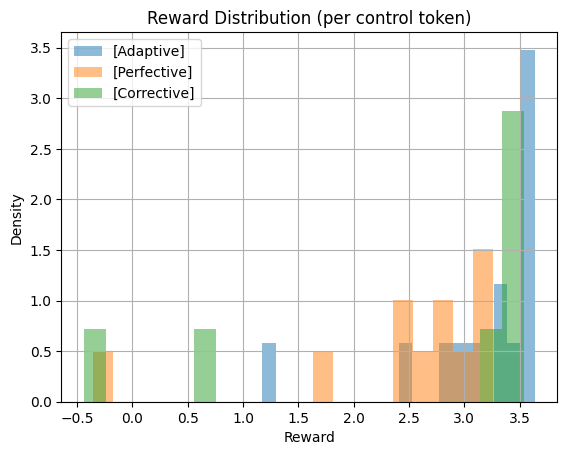

In [39]:
for ctrl_s in ctrl_str:
    vals = [
        r.item()
        for r, t in zip(rewards, task_list)
        if t == ctrl_s
    ]
    if len(vals) > 0:
        plt.hist(
            vals,
            bins=20,
            density=True,
            alpha=0.5,
            label=ctrl_s,
        )

plt.legend(loc="best")
plt.title("Reward Distribution (per control token)")
plt.xlabel("Reward")
plt.ylabel("Density")
plt.grid(True)
plt.show()

## Save model
Finally, we save the model to disk for later usage.

In [41]:
policy.save_pretrained("gpt2-imdb-ctrl")
tokenizer.save_pretrained("gpt2-imdb-ctrl")

('gpt2-imdb-ctrl/tokenizer_config.json',
 'gpt2-imdb-ctrl/special_tokens_map.json',
 'gpt2-imdb-ctrl/vocab.json',
 'gpt2-imdb-ctrl/merges.txt',
 'gpt2-imdb-ctrl/added_tokens.json',
 'gpt2-imdb-ctrl/tokenizer.json')

In [ ]:
#发送多种类型的邮件
from email.mime.multipart import MIMEMultipart
import smtplib

from email.mime.text import MIMEText
msg_from = '915803745@qq.com'  # 发送方邮箱
passwd = 'vcuosuurrgkfbdai'   #就是上面的授权码
 
# to= ['g.zhang@gotion.com', 'j.tong@gotion.com'] #接受方邮箱
to= ['j.tong@gotion.com'] #接受方邮箱
#设置邮件内容
#MIMEMultipart类可以放任何内容
msg = MIMEMultipart()
conntent=f"{fewshot_metrics}"
#把内容加进去
msg.attach(MIMEText(conntent,'plain','utf-8'))
 
#设置邮件主题
msg['Subject']="PPO学习模型训练完毕"
 
#发送方信息
msg['From']=msg_from
 
#开始发送
 
#通过SSL方式发送，服务器地址和端口
s = smtplib.SMTP_SSL("smtp.qq.com", 465)
# 登录邮箱
s.login(msg_from, passwd)
#开始发送
s.sendmail(msg_from,to,msg.as_string())
print("强化学习模型训练完毕")